In [1]:
#필요한 라이브러리 import
import pandas as pd
import folium
import json
import seaborn as sns
import matplotlib.pyplot as plt

/opt/app-root/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [61]:
# 한글 깨짐 방지
from matplotlib import font_manager, rc
import matplotlib
# font_name=font_manager.FontProperties(fname="malgun.ttf").get_name()
# rc('font', family=font_name)
import warnings
warnings.filterwarnings("ignore")
path = 'font/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path, size=12)
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

In [63]:
sns.set(font=font_name)

In [2]:
file_path = 'data/'
nopark = pd.read_csv(file_path+'오산시_주정차단속.csv')
child =  pd.read_csv(file_path+'오산시_어린이보호구역.csv')

In [3]:
nopark.head()
# nopark.단속종류.value_counts()

,단속일자,단속위치,행정구역,스쿨존여부,단속위치_경도,단속위치_위도,단속종류
0,20181101,금암동 여계산로 부근,경기도 오산시 세교동,N,127.043462,37.170237,이동형CCTV단속
1,20181101,세교동 세마역로19번길,경기도 오산시 세교동,N,127.044770,37.181695,이동형CCTV단속
2,20181101,세교동 수목원로 부근,경기도 오산시 양산동,N,127.042200,37.186357,이동형CCTV단속
3,20181101,오산동 오산로272번길 부,경기도 오산시 원동,N,127.071732,37.150557,이동형CCTV단속
4,20181101,오산동 성호대로93번길,경기도 오산시 부산동,N,127.071757,37.150457,이동형CCTV단속


In [4]:
# 오산시가 아닌 행들은 다 지워주기
nopark = nopark[nopark['행정구역'].str.contains('오산시')]

In [4]:
child.head()

,시설종류,시설명,CCTV설치여부,CCTV설치대수,보호구역도로폭,보호구역_경도,보호구역_위도
0,특수학교,성심학교,N,0,25,127.017521,37.176762
1,초등학교,가수초등학교,Y,1,12,127.047957,37.148103
2,초등학교,광성초등학교,Y,2,12,127.039709,37.184197
3,초등학교,대호초등학교,Y,3,12,127.057889,37.159106
4,초등학교,매홀초등학교,Y,2,6,127.063282,37.162749


In [ ]:
# 스쿨존에서 단속 걸린 횟수

In [5]:
# 오산시 행정구역 동만잘라내기
nopark['EMD_KOR_NM'] = nopark['행정구역'].str.extract('(\w*동)')

In [6]:
# 오산시 각동별로 몇개단속이 있는지 count
traffic_check = nopark.EMD_KOR_NM.value_counts().to_frame()

In [7]:
traffic_check = traffic_check.reset_index()

In [8]:
traffic_check.columns = ['EMD_KOR_NM', '단속횟수']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


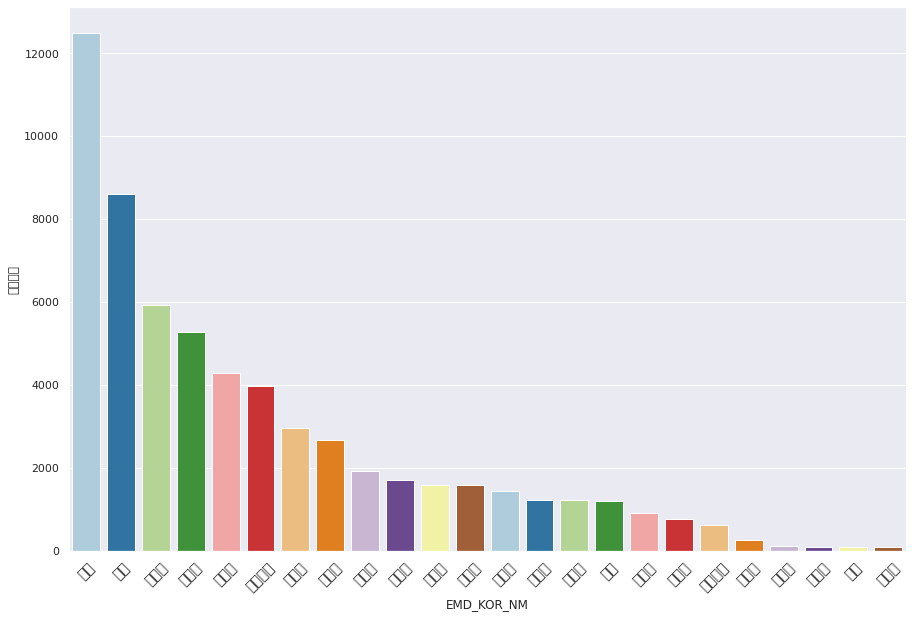

In [64]:
plt.figure(figsize=(15,10))
sns.barplot(x='EMD_KOR_NM',y='단속횟수',data=traffic_check, palette='Paired')
plt.xticks(rotation=45,size=14)
plt.show()

In [9]:
# 스쿨존존재가 Y인곳에 어떤 cctv단속종류가있는가?
# 주차 단속구역 스쿨존인 것만
school = nopark[nopark.스쿨존여부 =='Y']
school.단속종류.value_counts()

이동형CCTV단속    77
Name: 단속종류, dtype: int64

In [10]:
# 스쿨존 단속 dataframe
traffic_check_sc =  school.EMD_KOR_NM.value_counts().to_frame()
traffic_check_sc = traffic_check_sc.reset_index()
traffic_check_sc.columns = ['EMD_KOR_NM', '단속횟수']

In [12]:
child.시설종류.value_counts()

어린이집    48
초등학교    25
유치원     17
특수학교     1
Name: 시설종류, dtype: int64

In [72]:
# 어린이 보호구역  + 스쿨존에서 단속 위치
m = folium.Map(
    location=[37.149799,127.077116],
    zoom_start=11
)
for i in child.index:
    folium.Circle(
        location = child.loc[i, ['보호구역_위도', '보호구역_경도']],
        radius = 200,
        color='red',
        tooltip = child.loc[i,'시설명']
    ).add_to(m)
    
for i in school.index:
    folium.Marker(
        location = school.loc[i, ['단속위치_위도', '단속위치_경도']],
        tooltip = school.loc[i,'단속위치'],
        icon=folium.Icon(color = 'darkgreen',icon = 'flag'),
    ).add_to(m)
m

In [96]:
# 차량등록 현황 격자별로 주정차단속이 얼마나 되었는지
m = folium.Map(
    location=[37.149799,127.077116],
    zoom_start=11
)
 
with open(file_path+'/오산시_차량등록현황_격자.geojson',mode='rt',encoding='utf-8') as f:
    geo = json.loads(f.read())
    f.close()
 
folium.GeoJson(
    geo
).add_to(m)

m

In [25]:
geo_data= file_path+'오산시_법정경계(읍면동).geojson'
center = [37.149799,127.077116]

m = folium.Map(location=center, zoom_start=11)
folium.GeoJson(
    geo_data,
    style_function=lambda feature: {
        'fillColor': '#ADFF2F',
        'color': '#7CFC00',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(m)
    

for i in child.index:
    if child.loc[i,'시설종류'] == '어린이집':
        color = 'lightred'
        icon = 'baby'
    elif child.loc[i,'시설종류'] == '초등학교':
        color = 'cadetblue'
        icon = 'democrat'
    elif child.loc[i,'시설종류'] == '유치원':    
        color = 'lightblue'
        icon = 'child'
    else:    
        color = 'lightgray'
        icon = 'star'
    folium.Marker(
        location = child.loc[i, ['보호구역_위도', '보호구역_경도']],
        radius = 200,
        icon=folium.Icon(color = color,icon = icon, prefix='fa'),
        tooltip = child.loc[i,'시설명']
    ).add_to(m)

m

In [162]:
#오산시 어느동에서 주정차 단속이 가장많은가?
geo_data= file_path+'오산시_법정경계(읍면동).geojson'
center = [37.149799,127.077116]

m = folium.Map(location=center, zoom_start=11)

folium.Choropleth(
    geo_data=geo_data,
    data=traffic_check,
    columns=('EMD_KOR_NM','단속횟수'),
    key_on='feature.properties.EMD_KOR_NM',
    fill_color='YlGnBu',
    legend_name='주정차단속',
).add_to(m)

m

In [28]:
#오산시의 스쿨존중 어느곳에서 주정차 단속이 가장많은가?
geo_data= file_path+'오산시_법정경계(읍면동).geojson'
center = [37.149799,127.077116]

m = folium.Map(location=center, zoom_start=11)

folium.Choropleth(
    geo_data=geo_data,
    data=traffic_check_sc,
    columns=('EMD_KOR_NM','단속횟수'),
    key_on='feature.properties.EMD_KOR_NM',
    fill_color='YlGnBu',
    legend_name='주정차단속',
).add_to(m)

m